In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random as r
import matplotlib.pyplot as plt
from collections import Counter
import tqdm
from sklearn.base import clone
import ast

C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# 1. Load your datasets
# -----------------------------
print("Loading datasets...")
reviews_df = pd.read_csv("./archive/dataset.csv")  # columns: app_id, app_name, review_text
reviews_df.head(3)

Loading datasets...


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0


In [3]:
tags_df = pd.read_csv("comp/tagGamesNoCompoundDF.csv")
tagCountsDF = pd.read_csv("comp/tagCountsDF.csv")
tags_df.head(10)

,app_id,tags
0,10,"['action', 'first-person', 'shooter', 'multipl..."
1,1002,"['2d', 'fighting', 'martial arts', 'intentiona..."
2,100400,"['animation & modeling', 'software']"
3,10090,"['zombies', 'world war ii', 'first-person', 's..."
4,100980,"['animation & modeling', 'utilities', 'design ..."
5,10100,"['adventure', 'point & click', 'classic', 'fan..."
6,10110,"['adventure', 'point & click', 'classic', 'com..."
7,10120,"['action', 'casual', 'space', 'on-rails shoote..."
8,10130,"['action', 'first-person', 'shooter', 'time ma..."
9,10140,"['sports', 'mini golf', 'golf', 'local multipl..."


In [4]:
def filter_rare_tags_by_game(filterDF, tagCountsDF, min_count=1, max_count=7000):
    # Keep tags within the occurrence thresholds
    allowed_tags = set(tagCountsDF.loc[
        (tagCountsDF['occurrences'] >= min_count) & (tagCountsDF['occurrences'] <= max_count),
        'tag'
    ])

    tags_df = filterDF.copy()
    
    # Filter tags per game
    tags_df['tags'] = tags_df['tags'].apply(lambda lst: [tag for tag in lst if tag in allowed_tags])
    
    # Drop games with no tags left
    tags_df = tags_df[tags_df['tags'].str.len() > 0]
    
    return tags_df


In [5]:
excludedTags = [
    "Software", "Utilities", "Design & Illustration", "Photo Editing", 
    "Education", "Game Development", "Programming", "Software Training",
    "Web Publishing", "Video Production", "Audio Production", "Tutorial",
    "Coding", "Hardware", "360 Video"
]
def exclude_tags(df, excludedTags):

    excludedTags = [t.lower() for t in excludedTags]

    exclude_set = set(excludedTags)
    df_filtered = df.copy()
    
    df_filtered['tags'] = df_filtered['tags'].apply(
        lambda lst: [tag for tag in lst if tag not in exclude_set]
    )
    
    # Drop games with no tags left
    df_filtered = df_filtered[df_filtered['tags'].str.len() > 0]
    
    return df_filtered

In [6]:
# -----------------------------
# 2. Aggregate reviews per game (only games with tags available)
# -----------------------------

def aggregate_reviews_per_game(reviews_df: pd.DataFrame, tags_df: pd.DataFrame) -> pd.DataFrame:
    print("Aggregating reviews per game...")

    # Standardize key column name
    reviews_df["app_id"] = reviews_df["app_id"].astype(int, copy=False)
    tags_df["app_id"] = tags_df["app_id"].astype(int, copy=False)

    # Filter reviews that have tags
    reviews_with_tags = (
        reviews_df.loc[reviews_df['app_id'].isin(tags_df['app_id']), ['app_id', 'app_name', 'review_text']]
        .assign(review_text=lambda df: df['review_text'].astype(str))
    )

    # Filter short reviews
    reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)
    reviews_with_tags = reviews_with_tags.loc[
        reviews_with_tags['review_text'].str.count(r'\S+') >= 3
    ]
    print(f"Filtered reviews shape: {reviews_with_tags.shape}")

    # Aggregate per game
    game_reviews = (
        reviews_with_tags
        .groupby("app_id", as_index=False)
        .agg({
            'review_text': lambda texts: " ".join(texts),
            'app_name': 'first'
        })
    )
    print(f"Aggregated reviews shape: {game_reviews.shape}")

    # Merge and parse tags
    game_reviews = game_reviews.merge(tags_df, on="app_id", how='inner')
    game_reviews['tags'] = game_reviews['tags'].apply(ast.literal_eval)

    print(f"Merged game_reviews shape: {game_reviews.shape}")
    print("Sample of final aggregated data:")
    print(game_reviews.head(3))

    return game_reviews

game_reviews = aggregate_reviews_per_game(reviews_df, tags_df)

Aggregating reviews per game...
Filtered reviews shape: (6258189, 3)
Aggregated reviews shape: (9960, 3)
Merged game_reviews shape: (9960, 4)
Sample of final aggregated data:
   app_id                                        review_text  \
0      10  Ruined my life. This will be more of a ''my ex...   
1      20  When I got this for Christmas in 1999 along wi...   
2      30  Even though its old, its better than Call of D...   

                app_name                                               tags  
0         Counter-Strike  [action, first-person, shooter, multiplayer, s...  
1  Team Fortress Classic  [action, first-person, shooter, multiplayer, c...  
2          Day of Defeat  [first-person, shooter, world war ii, multipla...  


In [7]:
# lengths = ([len(i) for i in game_reviews['review_text']])
# reviews = []

# reviews_counts = reviews_df.groupby('app_id').size()
# tags_lookup = game_reviews.set_index('app_id')['tags']

# for app_id, count in tqdm.tqdm(reviews_counts.items()):
#     num_tags = len(tags_lookup.get(app_id, []))
#     reviews.append(np.array([count, num_tags]))

# reviews = np.array(reviews)


# # reviews = Counter(reviews)
# print(len(reviews)) # 4521
# print(max(reviews_counts)) # 88973
# print(min(reviews_counts)) # 1

# print(reviews)

In [8]:
# def filter_by_review_threshold(reviews, max_reviews):
#     return [r for r in reviews if r[0] <= max_reviews]

# plt.figure(figsize=(12,10))

# reviews = filter_by_review_threshold(reviews, 500)
# x = [r[0] for r in reviews]  # number of reviews
# y = [r[1] for r in reviews]  # number of tags

# plt.scatter(x, y , color="skyblue", edgecolor="black")

# plt.title("")
# plt.xlabel("# Reviews")
# plt.ylabel("# Tags")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [9]:
# reviews = reviews[reviews[:, 1].argsort()]
# reviews

In [10]:
# min_reviews_for_tag = [[i, None, None, None] for i in range(21)]

# min_reviews = 0

# # assuming your array is named arr
# for tag in range(21):
#     # filter rows where column 1 == tag
#     values = reviews[reviews[:, 1] == tag][:, 0]
#     if values.size > 0:
#         min_reviews_for_tag[tag][1] = values.min()
#         min_reviews_for_tag[tag][2] = values.max()
#         min_reviews_for_tag[tag][3] = round(values.mean(), 3)



# (np.array(min_reviews_for_tag))



In [11]:
# -----------------------------
# 3. Encode text to embeddings
# -----------------------------
original_indices = game_reviews.index.values

def encode_and_save_embeddings(game_reviews, model_name="all-mpnet-base-v2", output_file="base_test.npy"):
    print("Encoding text to embeddings...")
    model = SentenceTransformer(model_name)
    data = model.encode(game_reviews['review_text'].tolist(), show_progress_bar=True)
    np.save(output_file, data)
    return data

reembed = False
if reembed:
    data = encode_and_save_embeddings(game_reviews)
else:
    data = np.load("game_review_embeddings--all-mpnet-base-v2--NoCompound.npy")


In [12]:
game_reviews_filtered = filter_rare_tags_by_game(game_reviews, tagCountsDF, min_count=1, max_count=7000)
game_reviews_filtered = exclude_tags(game_reviews_filtered, excludedTags)

game_reviews_filtered = game_reviews_filtered[game_reviews_filtered['tags'].map(bool)]

filtered_embeddings = data[game_reviews_filtered.index]

(game_reviews_filtered.head(2))


,app_id,review_text,app_name,tags
0,10,Ruined my life. This will be more of a ''my ex...,Counter-Strike,"[action, first-person, shooter, multiplayer, s..."
1,20,When I got this for Christmas in 1999 along wi...,Team Fortress Classic,"[action, first-person, shooter, multiplayer, c..."


In [13]:
# Count how many entries have empty tag lists
empty_count = (game_reviews_filtered['tags'].apply(len) == 0).sum()
print(f"Number of entries with empty tags: {empty_count}")

# Total number of rows in the DataFrame
print(f"Total entries: {len(game_reviews_filtered['tags'])}")

Number of entries with empty tags: 0
Total entries: 9905


In [14]:
# Compare text from filtered DataFrame and embeddings
keep_positions = np.where(np.isin(original_indices, game_reviews.index.values))[0]
for i in range(5):
    idx_in_original = keep_positions[i]
    assert game_reviews.iloc[idx_in_original]['review_text'] == game_reviews_filtered.iloc[i]['review_text']


In [15]:
# -----------------------------
# 4. Encode tags to multilabel format
# -----------------------------
print("Encoding tags to multilabel format...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(game_reviews_filtered['tags'])

print(filtered_embeddings.shape)
print(y.shape)  

Encoding tags to multilabel format...
(9905, 768)
(9905, 401)


In [16]:
# -----------------------------
# 5. Train/Test split
# -----------------------------
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test, train_ids, test_ids, train_names, test_names = train_test_split(
    filtered_embeddings, y, game_reviews_filtered['app_id'], game_reviews_filtered['app_name'], test_size=0.33, random_state=42
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Splitting data into train and test sets...
(6636, 768) (6636, 401) (3269, 768) (3269, 401)


In [17]:
from sklearn.model_selection import KFold

def kfoldprobs(X_train, y_train, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Store test probabilities from each fold
    test_probs_folds = []

    for train_index, val_index in tqdm.tqdm(kf.split(X_train)):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
        clf.fit(X_tr, y_tr)

        # Predict probabilities on your **held-out test set** (not validation fold)
        probs_test = clf.predict_proba(X_test)
        test_probs_folds.append(probs_test)

    # Average probabilities across folds
    probs_test_avg = np.mean(test_probs_folds, axis=0)
    return probs_test_avg


In [18]:
def median_class_weights_linear(X_train, y_train, X_test):
    n_labels = y_train.shape[1]
    label_counts = np.sum(y_train, axis=0)
    median_count = np.median(label_counts)
    
    # Compute per-label median-based weights
    median_class_weights = [{0: 1.0, 1: (median_count / count)*1.8} for count in label_counts]
    
    # Train one LogisticRegression per label
    y_pred = []
    base_clf = LogisticRegression(max_iter=10000, solver='liblinear')
    for i in range(n_labels):
        clf = clone(base_clf)
        clf.set_params(class_weight=median_class_weights[i])
        clf.fit(X_train, y_train[:, i])
        y_pred.append(clf.predict_proba(X_test)[:, 1])  # get probability for positive class
    
    # Stack predictions as (n_samples, n_labels)
    return np.column_stack(y_pred)


In [19]:
# -----------------------------
# 6. Train multilabel classifier
# -----------------------------
def simple_linear(X_train, y_train):
    print("Training multilabel classifier...")
    clf = OneVsRestClassifier(LogisticRegression(max_iter=10000))
    clf.fit(X_train, y_train)
    return clf.predict_proba(X_test)

In [20]:
# Pick top 5 tags per game
def get_top_n_tags(probs, top_n=20):
    top_n_pred_tags = []
    for prob_row in probs:
        top_indices = prob_row.argsort()[-top_n:][::-1]  # indices of top N probs
        top_tags = [mlb.classes_[i] for i in top_indices]
        top_n_pred_tags.append(top_tags)
    return top_n_pred_tags

def get_treshhold_tags(probs, threshold=0.25):
    dynamic_pred_tags = []

    for prob_row in probs:
        # Get indices where probability > threshold
        tag_indices = np.where(prob_row > threshold)[0]

        if len(tag_indices) == 0:
            # fallback: pick the top 1 tag
            tag_indices = [np.argmax(prob_row)]

        tags = [mlb.classes_[i] for i in tag_indices]
        dynamic_pred_tags.append(tags)
    return dynamic_pred_tags   

In [21]:
probsl = simple_linear(X_train, y_train)
# probsm = median_class_weights_linear(X_train, y_train, X_test)
# kprobs = kfoldprobs(X_train, y_train, X_test, n_splits=10)


Training multilabel classifier...


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 170 is present in all training examples.
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 337 is present in all training examples.
  warnings.warn(


In [22]:
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score

# Convert top-N predicted tag names to a binary matrix
def get_Y_pred(top_n_pred_tags):
    y_pred = np.zeros_like(y_test)

    for i, tags in enumerate(top_n_pred_tags):
        for tag in tags:
            if tag in mlb.classes_:
                idx = list(mlb.classes_).index(tag)
                y_pred[i, idx] = 1
    return y_pred



# y_test: actual multilabel binary matrix
# y_pred: predicted multilabel binary matrix
def ceval(top_n_pred_tags):
    y_pred = get_Y_pred(top_n_pred_tags)
    # Hamming Loss
    hl = hamming_loss(y_test, y_pred)
    print("Hamming Loss:", hl)

    # Micro-averaged precision, recall, F1 (across all games)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')

    print(f"Micro Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    # Macro-averaged F1 (average per tag)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1 (per tag): {f1_macro:.3f}")

In [88]:
for i in [0.1, 0.15, 0.2, 0.25, .3]:
    print("\n ----------- \nResults for threshold =", i)
    top_n_pred_tags = get_treshhold_tags(probsl, threshold=i)
    # print("Results for simple linear model:")
    # ceval(top_n_pred_tags)
    # top_n_pred_tags = get_top_n_tags(probsl, top_n=5)
    # print("\n ----------- \nResults for simple linear model (top 8):")
    # top_n_pred_tags = get_treshhold_tags(probsm, threshold=i)
    print("\n ----------- \nResults for median class weights linear model:")
    # top_n_pred_tags = get_treshhold_tags( kprobs, threshold=i)
    # print("\n ----------- \nResults for k-fold model:")
    ceval(top_n_pred_tags)


 ----------- 
Results for threshold = 0.1

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.04657826220621588
Micro Precision: 0.325, Recall: 0.664, F1: 0.436


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Macro F1 (per tag): 0.159

 ----------- 
Results for threshold = 0.15

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.034107145717840605
Micro Precision: 0.410, Recall: 0.578, F1: 0.479


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Macro F1 (per tag): 0.144

 ----------- 
Results for threshold = 0.2

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.02874276529538802
Micro Precision: 0.473, Recall: 0.514, F1: 0.493


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Macro F1 (per tag): 0.129

 ----------- 
Results for threshold = 0.25

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.02569669433024963
Micro Precision: 0.532, Recall: 0.457, F1: 0.491


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Macro F1 (per tag): 0.114

 ----------- 
Results for threshold = 0.3

 ----------- 
Results for median class weights linear model:
Hamming Loss: 0.024127506257299546
Micro Precision: 0.580, Recall: 0.407, F1: 0.478
Macro F1 (per tag): 0.100


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [89]:
# -----------------------------
# 7. Predict and align with game info
# -----------------------------

actual_tags = mlb.inverse_transform(y_test) 


# Example: print top 5 predicted tags for first 5 games
gam = r.randint(0, len(test_names)-1)
for i in range(gam, gam+5):
    print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
    print("  Predicted tags:", top_n_pred_tags[i])  # only show tags not in actual
    print("  Actual tags   :", list(actual_tags[i]))
    print(f"{len(set(top_n_pred_tags[i]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
    print()
# -----------------------------
# gam = r.randint(0, len(test_names)-1)
# for i in range(gam, gam+5):
#     print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
#     print("  Predicted tags:", top_n_pred_tags[i][:len(actual_tags[i])])
#     print("  Actual tags   :", list(actual_tags[i]))
#     print(f"{len(set(top_n_pred_tags[i][:len(actual_tags[i])]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
#     print()


The Solus Project (app_id=313630)
  Predicted tags: ['action', 'adventure', 'first-person', 'indie', 'vr']
  Actual tags   : ['adventure', 'atmospheric', 'crafting', 'exploration', 'first-person', 'horror', 'indie', 'mystery', 'open world', 'psychological', 'sandbox', 'sci-fi', 'simulation', 'singleplayer', 'space', 'story rich', 'survival', 'vr', 'walking simulator']
4/19 tags correct

Goblin and Coins (app_id=551580)
  Predicted tags: ['action', 'adventure', 'casual', 'indie', 'platformer', 'singleplayer', 'strategy']
  Actual tags   : ['1980s', '2d', 'action', 'adventure', 'cartoony', 'controller', 'cooking', 'cute', 'difficult', 'family friendly', 'fantasy', 'linear', 'medieval', 'perma death', 'pixel graphics', 'platformer', 'side scroller', 'singleplayer', 'villain protagonist']
4/19 tags correct

LOST ORBIT (app_id=282640)
  Predicted tags: ['2d', 'adventure', 'casual', 'indie', 'puzzle', 'sci-fi', 'singleplayer', 'space']
  Actual tags   : ['action', 'adventure', 'blood', 'diff

In [90]:
from collections import defaultdict

tag_correct = defaultdict(int)      # how many times a tag was correctly predicted
tag_pred_total = defaultdict(int)   # how many times a tag was predicted
tag_actual_total = defaultdict(int) # how many times a tag actually appeared

# Loop through full test set
for pred_tags, act_tags in zip(top_n_pred_tags, actual_tags):
    pred_set = set(pred_tags)
    act_set = set(act_tags)

    # Count actual appearances
    for t in act_set:
        tag_actual_total[t] += 1

    # Count predictions
    for t in pred_set:
        tag_pred_total[t] += 1

    # Count correct predictions (intersection)
    for t in pred_set & act_set:
        tag_correct[t] += 1


In [112]:

tagStats = pd.DataFrame({
    'Correct': pd.Series(tag_correct),
    'Predicted': pd.Series(tag_pred_total),
    'Actual': pd.Series(tag_actual_total),
})

tagStats['Precision'] = tagStats['Correct'] / tagStats['Predicted']  # How reliable predictions were
tagStats['Recall'] = tagStats['Correct'] / tagStats['Actual']        # How often tag was caught
tagStats['F1'] = 2 * tagStats['Precision'] * tagStats['Recall'] / (tagStats['Precision'] + tagStats['Recall'])
tagStats['F1'] = tagStats['F1'].fillna(0)  # handle divide by zero if needed

tagStats['PR_dif'] = abs(tagStats['Precision'] - tagStats['Recall'])
tagStats['PA_ratio'] = abs(tagStats['Predicted'] / tagStats['Actual'])

tagStats = tagStats.fillna(0).sort_values('F1', ascending=False)


In [118]:
# tagStats.sort_values('Correct', ascending=False).head(10)
tagStats[tagStats['Predicted'] > 5].sort_values('Precision', ascending=True).head(25)
# tagStats[tagStats['Actual'] > 5].sort_values('Recall').head(10)
# tagStats.sort_values('F1', ascending=False).head(25)
# tagStats.sort_values('PR_dif', ascending=False).head(10)
# tagStats.sort_values('PA_ratio', ascending=False).head(10)


,Correct,Predicted,Actual,Precision,Recall,F1,PR_dif,PA_ratio
interactive fiction,1.0,6.0,45,0.166667,0.022222,0.039216,0.144444,0.133333
multiple endings,2.0,9.0,58,0.222222,0.034483,0.059701,0.187739,0.155172
exploration,20.0,65.0,230,0.307692,0.086957,0.135593,0.220736,0.282609
hack and slash,2.0,6.0,94,0.333333,0.021277,0.040000,0.312057,0.063830
comedy,27.0,77.0,254,0.350649,0.106299,0.163142,0.244350,0.303150
great soundtrack,159.0,438.0,536,0.363014,0.296642,0.326489,0.066372,0.817164
sandbox,55.0,150.0,249,0.366667,0.220884,0.275689,0.145783,0.602410
tactical,39.0,106.0,198,0.367925,0.196970,0.256579,0.170955,0.535354
short,5.0,13.0,129,0.384615,0.038760,0.070423,0.345856,0.100775
arcade,76.0,193.0,317,0.393782,0.239748,0.298039,0.154035,0.608833


In [120]:
def get_per_tag_means(tagStats:pd.DataFrame):
    means={}
    for c in tagStats.columns:
        means[c] = round(np.mean(np.array(tagStats[tagStats['Predicted'] > 5][c])), 3)
    return means

get_per_tag_means(tagStats=tagStats)

{'Correct': 135.131,
 'Predicted': 233.131,
 'Actual': 266.579,
 'Precision': 0.592,
 'Recall': 0.301,
 'F1': 0.359,
 'PR_dif': 0.326,
 'PA_ratio': 0.508}

In [102]:
def find_unpredicted_tags(top_n_pred_tags, actual_tags):
    return set([item for sublist in actual_tags for item in sublist]) - set([item for sublist in top_n_pred_tags for item in sublist])
unpredicted_tags = find_unpredicted_tags(top_n_pred_tags, actual_tags)
print(f"{len(unpredicted_tags)} Unpredicted tags:", unpredicted_tags)

255 Unpredicted tags: {'crpg', 'supernatural', 'hentai', 'steam machine', 'fishing', 'abstract', 'pinball', 'spaceships', 'drama', 'mining', 'dwarf', 'sokoban', 'hand-drawn', 'mythology', 'nostalgia', 'philosophical', 'hunting', 'team-based', 'hockey', 'remake', 'level editor', 'replay value', 'cyberpunk', 'dragons', 'feature film', 'dinosaurs', 'character action game', 'wrestling', 'benchmark', 'illuminati', 'spelling', 'cartoony', 'voxel', 'narration', 'epic', 'dog', '2.5d', 'mystery dungeon', 'pool', 'parkour', 'split screen', 'baseball', 'clicker', 'steampunk', 'god game', 'card battler', 'agriculture', 'vr only', 'loot', 'narrative', 'destruction', 'america', 'colony sim', '6dof', 'inventory management', 'elf', 'football', 'atv', 'music-based procedural generation', 'sniper', 'time manipulation', 'roguevania', 'twin stick shooter', 'swordplay', 'science', 'crowdfunded', 'outbreak sim', 'time attack', 'robots', 'snow', 'farming', 'archery', 'medical sim', 'linear', 'tennis', 'rugby

In [104]:

def find_top_x(li, x=10, print_output=True):
    flat = np.array([item for sublist in li for item in sublist])
    # Get unique tags and counts
    unique, counts = np.unique(flat, return_counts=True)
    print(len(flat), len(unique))

    # Sort tags by descending frequency
    sorted_indices = np.argsort(-counts)
    most_common_items = unique[sorted_indices]
    most_common_counts = counts[sorted_indices]

    # Print top 10 tags
    if print_output:
        print("Top tags:")
        for item, count in zip(most_common_items[:x], most_common_counts[:x]):
            print(f"{item}: {count}")
    return most_common_items[:x], most_common_counts[:x]

X= np.unique(np.concatenate(top_n_pred_tags)).size
top_pred = find_top_x(top_n_pred_tags, x=X, print_output=False)
top_act = find_top_x(actual_tags, x=X, print_output=False)


print(len(top_pred[0]), len(top_act[0]), len(top_pred[1]), len(top_act[1]))
df_compare = pd.DataFrame({
    'pred_Tag': [t for t in top_pred[0]],
    'pred_count': [s for s in top_pred[1]],
    'act_Tag': [t for t in top_act[0]],
    'act_count': [s for s in top_act[1]]
})

df_compare.head(15)

25031 138
35617 393
138 138 138 138


,pred_Tag,pred_count,act_Tag,act_count
0,indie,2892,indie,2051
1,singleplayer,2570,action,1702
2,action,2332,singleplayer,1512
3,adventure,2167,adventure,1420
4,casual,1483,casual,1138
5,strategy,1034,strategy,859
6,multiplayer,822,simulation,734
7,simulation,775,multiplayer,676
8,rpg,739,rpg,665
9,2d,640,2d,646


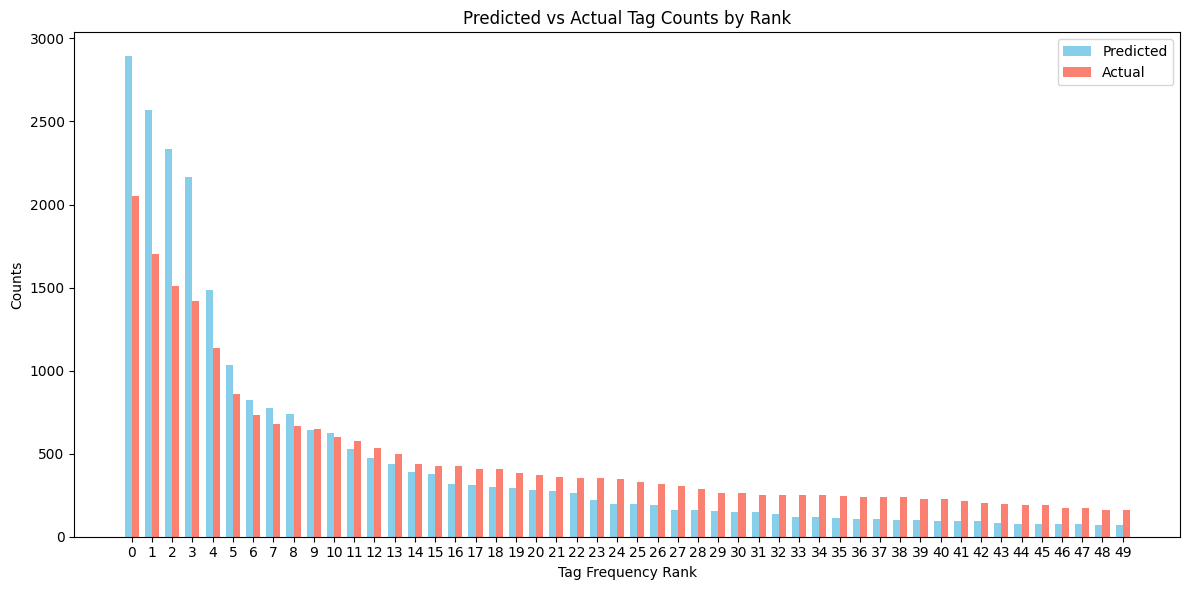

In [105]:

def countHistogram(df_compare:pd.DataFrame, top=35, labels=True):
    top_n = top
    df_top = df_compare.head(top_n)

    x = np.arange(top_n)  # positions for each tag
    width = 0.35          # width of bars

    fig, ax = plt.subplots(figsize=(12,6))

    # Bars
    ax.bar(x - width/2, df_top['pred_count'], width, label='Predicted', color='skyblue')
    ax.bar(x + width/2, df_top['act_count'], width, label='Actual', color='salmon')

    # Labels
    ax.set_ylabel('Counts')
    ax.set_xlabel('Tag Frequency Rank')
    ax.set_title('Predicted vs Actual Tag Counts by Rank')
    ax.set_xticks(x)
    if labels:
        ax.set_xticklabels(df_top['pred_Tag'], rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

countHistogram(df_compare, top=min(np.unique(np.concatenate(top_n_pred_tags)).size, 50),labels=False)

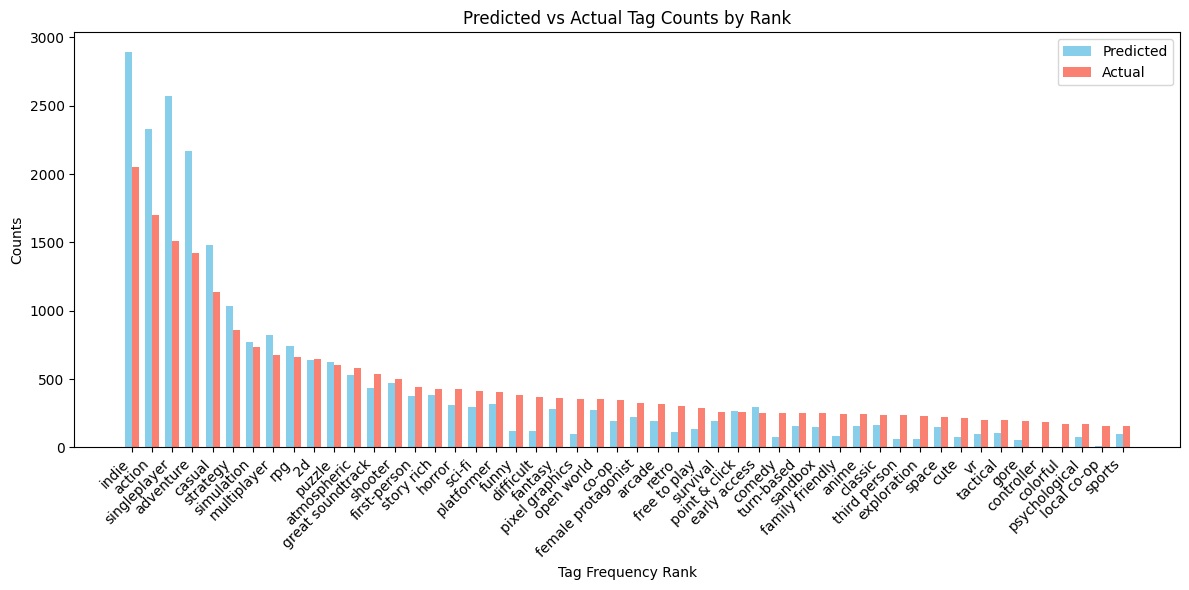

In [106]:
# Make a mapping from predicted tags to their counts
pred_map = dict(zip(top_pred[0], top_pred[1]))

# Reorder pred counts to follow actual tag ordering
new_act_tags = top_act[0]                  # actual tags are the reference
new_pred_counts = [pred_map.get(tag, 0) for tag in new_act_tags]  # fallback 0 if missing

# Build dataframe using aligned lists
df_compare = pd.DataFrame({
    'pred_Tag': new_act_tags,        # aligned with actual tags
    'pred_count': new_pred_counts,   # predicted counts reordered
    'act_Tag': new_act_tags,
    'act_count': top_act[1]
})

countHistogram(df_compare, top=min(np.unique(np.concatenate(top_n_pred_tags)).size, 50))


In [107]:

def plot_tag_count_distribution_hist(pred_counts, actual_counts, bins=20, title="Tag Count Distribution"):
    """
    Plots the distribution of tag counts using a histogram with bins and a line overlay.
    
    Args:
        pred_counts (array-like): counts of each predicted tag
        actual_counts (array-like): counts of each actual tag
        bins (int or sequence): number of bins or bin edges
        title (str): plot title
    """
    plt.figure(figsize=(12,6))
    
    # Histogram for actual counts
    counts_actual, bin_edges = np.histogram(actual_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, counts_actual, width=(bin_edges[1]-bin_edges[0])*0.4, alpha=0.6,
            label='Actual', color='salmon', edgecolor='black')
    plt.plot(bin_centers, counts_actual, color='red', marker='o', linestyle='-', label='Actual (line)')
    
    # Histogram for predicted counts
    counts_pred, _ = np.histogram(pred_counts, bins=bin_edges)
    plt.bar(bin_centers + (bin_edges[1]-bin_edges[0])*0.4, counts_pred, width=(bin_edges[1]-bin_edges[0])*0.4,
            alpha=0.6, label='Predicted', color='skyblue', edgecolor='black')
    plt.plot(bin_centers, counts_pred, color='blue', marker='o', linestyle='-', label='Predicted (line)')
    
    plt.xlabel("Number of occurrences of a tag")
    plt.ylabel("Number of tags in that bin")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [108]:
def tag_distribution_report(tag_tuple, name="Tag Distribution"):
    """
    Generate a report on the distribution of tag counts.
    tag_tuple: tuple (tags_list, counts_list)
    name: label of the dataset (e.g. 'Predicted' or 'Actual')
    """
    tags, counts = tag_tuple
    counts = np.array(counts)

    report = {
        "Dataset Name": name,
        "Total Unique Tags": len(tags),
        "Total Tag Assignments": counts.sum(),
        "Mean Tag Frequency": counts.mean(),
        "Median Tag Frequency": np.median(counts),
        "Min Tag Frequency": counts.min(),
        "Max Tag Frequency": counts.max(),
        "Std Dev": counts.std(),
        "10th Percentile": np.percentile(counts, 10),
        "25th Percentile": np.percentile(counts, 25),
        "50th Percentile": np.percentile(counts, 50),
        "75th Percentile": np.percentile(counts, 75),
        "90th Percentile": np.percentile(counts, 90),
        "Tags Occurring Once": np.sum(counts == 1),
        "Tags Occurring <= 5": np.sum(counts <= 5),
        "Top 10 Tags Coverage (%)": round(100 * counts[:10].sum() / counts.sum(), 2)
    }

    return pd.DataFrame.from_dict(report, orient='index', columns=[name])


25031 138
35617 393
                          Predicted Tags
Dataset Name              Predicted Tags
Total Unique Tags                    138
Total Tag Assignments              25031
Mean Tag Frequency            181.384058
Median Tag Frequency                27.0
Min Tag Frequency                      1
Max Tag Frequency                   2892
Std Dev                       454.772173
10th Percentile                      2.7
25th Percentile                      6.0
50th Percentile                     27.0
75th Percentile                    115.5
90th Percentile                    402.3
Tags Occurring Once                    9
Tags Occurring <= 5                   31
Top 10 Tags Coverage (%)           61.74 
                           Actual Tags
Dataset Name              Actual Tags
Total Unique Tags                 393
Total Tag Assignments           35617
Mean Tag Frequency          90.628499
Median Tag Frequency             25.0
Min Tag Frequency                   1
Max Tag Frequen

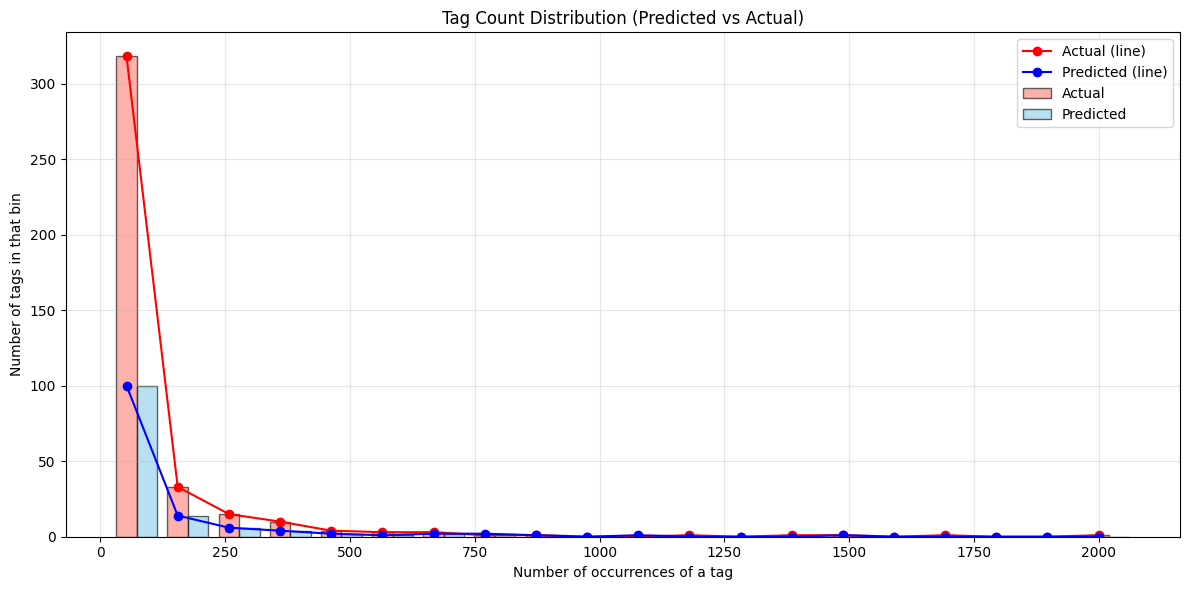

In [109]:
top_pred = find_top_x(top_n_pred_tags, x=len(top_n_pred_tags), print_output=False)
top_act = find_top_x(actual_tags, x=len(actual_tags), print_output=False)

print(tag_distribution_report(top_pred, name="Predicted Tags"), "\n",
tag_distribution_report(top_act, name="Actual Tags"))
plot_tag_count_distribution_hist(top_pred[1], top_act[1], title="Tag Count Distribution (Predicted vs Actual)")